In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from  sklearn.metrics import mean_squared_error, mean_absolute_error

import import_ipynb
import TimeSeriesFunctions as tsf

In [2]:
data=pd.read_csv('data.csv', index_col=0)

C:\Users\Utente\Miniconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Drop means, not correct and recompute

In [3]:
data.drop(['city_mean','shop_mean','item_type_mean','subtype_mean','tot_revenues'],1,inplace=True)

In [4]:
data=data.rename(columns={'datecode':'date_block_num','item_count':'item_cnt_month'})
data.columns

Index(['date_block_num', 'shop_id', 'city_code', 'item_id', 'item_category_id',
       'type', 'subtype', 'item_cnt_month', 'tot_revenues', 'item_count_lag_1',
       'item_count_lag_2', 'item_count_lag_3', 'item_count_lag_6',
       'item_count_lag_12', 'item_count_lag_1_trend6',
       'item_count_lag_1_trend12'],
      dtype='object')

Feature extraction

In [5]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [6]:
#Compute thee average quantity sold per month
group = data.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)
##merge
data = pd.merge(data, group, on=['date_block_num','item_id'], how='left')
data['date_item_avg_item_cnt'] = data['date_item_avg_item_cnt'].astype(np.float16)
## use lag feature as before
data = lag_feature(data, [1,2,3,6,12], 'date_item_avg_item_cnt')
data.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [7]:
data.columns

Index(['date_block_num', 'shop_id', 'city_code', 'item_id', 'item_category_id',
       'type', 'subtype', 'item_cnt_month', 'tot_revenues', 'item_count_lag_1',
       'item_count_lag_2', 'item_count_lag_3', 'item_count_lag_6',
       'item_count_lag_12', 'item_count_lag_1_trend6',
       'item_count_lag_1_trend12', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12'],
      dtype='object')

In [9]:
#Compute thee average quantity sold per month
group = data.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)
#merge
data = pd.merge(data, group,on=['date_block_num','shop_id'], how='left', suffixes=('', '_y'))
data.drop(data.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

data['date_shop_avg_item_cnt'] = data['date_shop_avg_item_cnt'].astype(np.float16)
## use lag feature as before
data = lag_feature(data, [1,2,3,6,12], 'date_shop_avg_item_cnt')
data.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [11]:
#Compute the average quantity sold per month, item_category
group = data.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

## merge
data = pd.merge(data, group, on=['date_block_num','item_category_id'], how='left', suffixes=('', '_y'))
data.drop(data.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
data['date_cat_avg_item_cnt'] = data['date_cat_avg_item_cnt'].astype(np.float16)
## use lag feature as before
data = lag_feature(data, [1], 'date_cat_avg_item_cnt')
data.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [12]:
def calculate_trend(df_in, lag_list, group_var, columns, fill_value = np.inf, replace_value = True):  
# X_trendN = 100 * [X(t)-X(t-N)]/X(t-N)
    df = df_in.copy()
    if isinstance(columns, list)==False:
        columns = [columns] 

    for column in columns:
        for lag in lag_list:
            trend_column_lag = column + "_trend" + str(lag)
            df[trend_column_lag] = 100 * (df.groupby(group_var)[column].shift(0) - 
                                          df.groupby(group_var)[column].shift(lag)) / \
                                          df.groupby(group_var)[column].shift(lag)
    
    if replace_value:
        df.replace([np.inf, -np.inf], 0, inplace=True) # generated by n/0
        df.fillna(0, inplace=True)                     # generated by 0/0
    return df 

In [14]:
lag_list = [1, 2, 3] 
data = calculate_trend(data, lag_list, ['shop_id', 'item_id'], columns=['item_count_lag_1'])

In [15]:
data.fillna(0,inplace=True)

In [16]:
df_copy=data.copy()

In [27]:
df_copy.columns

Index(['date_block_num', 'shop_id', 'city_code', 'item_id', 'item_category_id',
       'type', 'subtype', 'item_cnt_month', 'item_count_lag_1',
       'item_count_lag_2', 'item_count_lag_3', 'item_count_lag_6',
       'item_count_lag_12', 'item_count_lag_1_trend6',
       'item_count_lag_1_trend12', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'item_count_lag_1_trend1', 'item_count_lag_1_trend2',
       'item_count_lag_1_trend3'],
      dtype='object')

In [47]:
data=df_copy[['date_block_num', 'shop_id', 'item_id', 'item_category_id',
       'subtype', 'item_cnt_month', 'item_count_lag_1',
       'item_count_lag_2', 'item_count_lag_3', 'item_count_lag_6',
       'item_count_lag_12', 'item_count_lag_1_trend6',
       'item_count_lag_1_trend12', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'item_count_lag_1_trend1', 'item_count_lag_1_trend2',
       'item_count_lag_1_trend3']]
data=data[data['date_block_num']>=12]

In [48]:
print(data.shape)
print(data.columns)
data.head()

(6425094, 27)
Index(['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'subtype',
       'item_cnt_month', 'item_count_lag_1', 'item_count_lag_2',
       'item_count_lag_3', 'item_count_lag_6', 'item_count_lag_12',
       'item_count_lag_1_trend6', 'item_count_lag_1_trend12',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'item_count_lag_1_trend1',
       'item_count_lag_1_trend2', 'item_count_lag_1_trend3'],
      dtype='object')


,date_block_num,shop_id,item_id,item_category_id,subtype,item_cnt_month,item_count_lag_1,item_count_lag_2,item_count_lag_3,item_count_lag_6,...,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,item_count_lag_1_trend1,item_count_lag_1_trend2,item_count_lag_1_trend3
4488756,12,54,10297,37,1,4,3.0,0.0,0.0,0.0,...,0.0,1.186523,0.986328,0.000000,0.000000,0.0,0.234009,0.000000,0.0,0.0
4488757,12,54,10296,38,2,3,0.0,0.0,0.0,0.0,...,0.0,1.186523,0.000000,0.000000,0.000000,0.0,0.243774,0.000000,0.0,0.0
4488758,12,54,10298,40,6,14,21.0,119.0,7.0,0.0,...,0.0,1.186523,0.986328,0.830566,0.000000,0.0,0.309082,-82.352941,200.0,0.0
4488759,12,54,10300,37,1,3,1.0,31.0,0.0,0.0,...,0.0,1.186523,0.986328,0.830566,0.000000,0.0,0.234009,-96.774194,0.0,0.0
4488760,12,54,10284,57,10,1,0.0,0.0,0.0,1.0,...,0.0,1.186523,0.986328,0.830566,0.859375,0.0,0.138306,0.000000,0.0,0.0


In [49]:
def split(day_lim,date,df,target,day_lim_min=-1,day_lim_max=-1, just_train=False):
    train=df[df[date]<day_lim]
    test=df[df[date]>=day_lim]

    if just_train==True:
        return (train,test)
    else:

        X_train=train.drop([target],1)
        y_train=train[[target,date]]

        X_test=test.drop([target],1)
        y_test=test[[target,date]]

        if day_lim_max!=-1:
            X_validate=X_test[X_test[date]>day_lim_max]
            y_validate=y_test[y_test[date]>day_lim_max]
            X_test=X_test[X_test[date]<=day_lim_max]
            y_test=y_test[y_test[date]<=day_lim_max]

            y_train.drop(date,1,inplace=True)
            y_validate.drop(date,1,inplace=True)
            y_test.drop(date,1,inplace=True)
            print('train shape:',X_train.shape,y_train.shape)
            print('test shape:',X_test.shape,y_test.shape)
            print('validation shape:',X_validate.shape,y_validate.shape)

            return (X_train,y_train,X_test,y_test,X_validate,y_validate)    

        else:

            if day_lim_min!=-1:
                X_train=X_train[X_train[date]>=day_lim_min]
                y_train=y_train[y_train[date]>=day_lim_min]

            y_train.drop(date,1,inplace=True)
            y_test.drop(date,1,inplace=True)

            print('train shape:',X_train.shape,y_train.shape)
            print('test shape:',X_test.shape,y_test.shape)

            return (X_train,y_train,X_test,y_test)


In [50]:
X_train,y_train,X_test,y_test=split(day_lim=32,date='date_block_num',df=data,target='item_cnt_month')

C:\Users\Utente\Miniconda3\lib\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


train shape: (5968267, 26) (5968267, 1)
test shape: (456827, 26) (456827, 1)


In [51]:
print(X_train.columns)
print(y_train.columns)

Index(['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'subtype',
       'item_count_lag_1', 'item_count_lag_2', 'item_count_lag_3',
       'item_count_lag_6', 'item_count_lag_12', 'item_count_lag_1_trend6',
       'item_count_lag_1_trend12', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'item_count_lag_1_trend1', 'item_count_lag_1_trend2',
       'item_count_lag_1_trend3'],
      dtype='object')
Index(['item_cnt_month'], dtype='object')


### Modelling

LightGBM, gain importance features

In [52]:
#LightGBM = LGBMRegressor(boosting_type='goss', importance_type='gain') 
#LightGBM.fit(X_train, y_train) 


LGBMRegressor(boosting_type='goss', class_weight=None, colsample_bytree=1.0,
              importance_type='gain', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LightGBM, split importance features

In [ ]:
#LightGBM = LGBMRegressor(boosting_type='goss', importance_type='split') 
#LightGBM.fit(X_train, y_train) 


In [79]:
n_estimators = [int(x) for x in np.linspace(start = 90, stop = 150, num = 10)]
boosting_type = ['goss']

def params_opt(n_estimators, boosting_type):
    
    RMSE_win = np.inf
    opt_params = {'boosting_type': boosting_type, 'n_estimators': 100} 
    
    for trees in n_estimators:
        params_grid = {'boosting_type': boosting_type, 'n_estimators': trees} 
        model = LGBMRegressor(**params_grid) 
        model.fit(X_train, y_train) 
        y_train_pred = pd.Series(model.predict(X_train)).apply(lambda x: round(x))
        y_test_pred = pd.Series(model.predict(X_test)).apply(lambda x: round(x)) 
        RMSE = np.sqrt(mean_squared_error(y_test_pred, y_test)) 
        if RMSE<RMSE_win:
            RMSE_win = RMSE
            opt_params = {'boosting_type': boosting_type, 'n_estimators': trees}
    return RMSE_win, opt_params,y_test_pred,y_train_pred

In [80]:
RMSE_win,opt_params,test_pred,train_pred=params_opt(n_estimators,boosting_type)

In [81]:
RMSE_win

5.3323185839127785

In [82]:
opt_params

{'boosting_type': ['goss'], 'n_estimators': 143}

In [85]:
LightGBM = LGBMRegressor(**opt_params) 
LightGBM.fit(X_train, y_train) 

LGBMRegressor(boosting_type=['goss'], class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=143, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [86]:
y_train_pred = pd.Series(LightGBM.predict(X_train)).apply(lambda x: round(x))
y_test_pred = pd.Series(LightGBM.predict(X_test)).apply(lambda x: round(x))

In [87]:
print(f'MAE Train is {mean_absolute_error(y_train_pred, y_train)}')
print(f'RMSE Train is {np.sqrt(mean_squared_error(y_train_pred, y_train))}\n')
print(f'MAE Test is {mean_absolute_error(y_test_pred, y_test)}')
print(f'RMSE Test is {np.sqrt(mean_squared_error(y_test_pred, y_test))}') 

MAE Train is 0.2753253163774342
RMSE Train is 1.7844682328682835

MAE Test is 0.3086726485080786
RMSE Test is 5.3323185839127785


In [56]:
df_LGBM = pd.DataFrame(pd.Series(LightGBM.feature_importances_, index=X_train.columns).\
sort_values(ascending=False)).\
reset_index().\
rename(columns={'index':'feature',0:'score'})
df_LGBM['model'] = 'XGBoost'

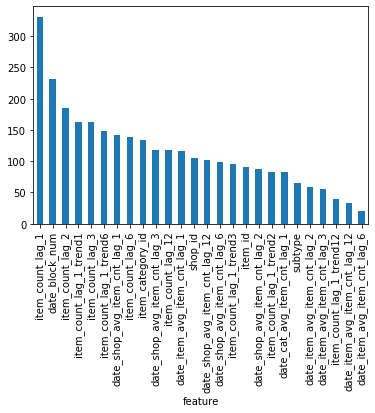

In [57]:
df_LGBM.set_index('feature')['score'].plot(kind='bar')
plt.show()

Cumulative error per month per shop-- N.B

In [68]:
shop=data[['date_block_num','shop_id','item_cnt_month']].reset_index()
shop.drop(['index'],1,inplace=True)
shop['pred']=pred
shops=shop.groupby(['date_block_num','shop_id']).sum().reset_index()

In [70]:
print(np.absolute(shops.item_cnt_month - shops.pred)) 
print(np.mean(np.absolute(shops.item_cnt_month - shops.pred))) 

0          8
1        142
2        147
3        433
4         26
5        407
6        117
7        281
8        103
9        219
10       340
11       165
12       204
13        73
14       603
15       139
16        36
17       340
18       643
19        13
20       635
21      1663
22        29
23       360
24       313
25       182
26       104
27        32
28       349
29       203
        ... 
1009    1376
1010     760
1011     421
1012     330
1013    1485
1014     252
1015     717
1016     800
1017      42
1018     460
1019    1279
1020      79
1021     175
1022     366
1023     173
1024    1759
1025     223
1026     151
1027     427
1028     477
1029     345
1030     101
1031     260
1032     126
1033     262
1034    1030
1035     455
1036     809
1037     451
1038      35
Length: 1039, dtype: int64
578.5851780558229


Cumulative error per month

In [59]:
# Graph predictions 
pred = pd.concat([pd.DataFrame(y_train_pred), pd.DataFrame(y_test_pred)]) 
pred = pred.rename({0:'pred'}, axis=1) 
pred = pred.apply(lambda x: round(x)) 
pred = pred.reset_index(drop=True) 
sales=data[['date_block_num','item_cnt_month']].reset_index()
sales.drop(['index'],1,inplace=True)
sales['predictions']=pred

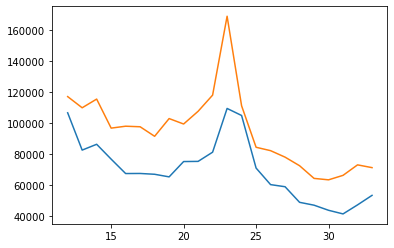

In [60]:
sales_group=sales.groupby('date_block_num').sum().reset_index()
sales_group
plt.plot(sales_group.date_block_num,sales_group.predictions)
plt.plot(sales_group.date_block_num,sales_group.item_cnt_month)

In [61]:
print(np.absolute(sales_group.item_cnt_month - sales_group.predictions)) 
print(np.mean(np.absolute(sales_group.item_cnt_month - sales_group.predictions))) 

0     10451
1     27315
2     29169
3     20009
4     30546
5     30137
6     24505
7     37628
8     24224
9     32332
10    36818
11    59497
12     6262
13    13413
14    21918
15    19092
16    23623
17    17291
18    19656
19    24889
20    25824
21    17893
dtype: int64
25113.272727272728
